The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [5]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release --no-deps --force-reinstall
!pip install numpy>=1.20

  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /tmp/pip-req-build-7h0tcm4u
  Running command git clone --filter=blob:none --quiet https://github.com/d2l-ai/d2l-zh /tmp/pip-req-build-7h0tcm4u
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  Branch 'release' set up to track remote branch 'release' from 'origin'.
  Resolved https://github.com/d2l-ai/d2l-zh to commit 843d3d41dca48d8df65f4b324dd171d8bfe9c067
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Created wheel for d2l: filename=d2l-2.0.0-py3-none-any.whl size=110800 sha256=af4b0205eeb6449734a577fb38b0a2941ca19926889492c7383f88e492f95141
  Stored in directory: /tmp/pip-ephem-wheel-cache-mfb2s3ug/wheels/53/15/45/14b38ed62d9bc53ab3de439d4c2a79f70a00112eeeadcf6c34
Successfully built d2l


# 序列模型
:label:`sec_sequence`

想象一下有人正在看网飞（Netflix，一个国外的视频网站）上的电影。
一名忠实的用户会对每一部电影都给出评价，
毕竟一部好电影需要更多的支持和认可。
然而事实证明，事情并不那么简单。
随着时间的推移，人们对电影的看法会发生很大的变化。
事实上，心理学家甚至对这些现象起了名字：

* *锚定*（anchoring）效应：基于其他人的意见做出评价。
  例如，奥斯卡颁奖后，受到关注的电影的评分会上升，尽管它还是原来那部电影。
  这种影响将持续几个月，直到人们忘记了这部电影曾经获得的奖项。
  结果表明（ :cite:`Wu.Ahmed.Beutel.ea.2017`），这种效应会使评分提高半个百分点以上。
* *享乐适应*（hedonic adaption）：人们迅速接受并且适应一种更好或者更坏的情况
  作为新的常态。
  例如，在看了很多好电影之后，人们会强烈期望下部电影会更好。
  因此，在许多精彩的电影被看过之后，即使是一部普通的也可能被认为是糟糕的。
* *季节性*（seasonality）：少有观众喜欢在八月看圣诞老人的电影。
* 有时，电影会由于导演或演员在制作中的不当行为变得不受欢迎。
* 有些电影因为其极度糟糕只能成为小众电影。*Plan9from Outer Space*和*Troll2*就因为这个原因而臭名昭著的。

简而言之，电影评分决不是固定不变的。
因此，使用时间动力学可以得到更准确的电影推荐 :cite:`Koren.2009`。
当然，序列数据不仅仅是关于电影评分的。
下面给出了更多的场景。

* 在使用程序时，许多用户都有很强的特定习惯。
  例如，在学生放学后社交媒体应用更受欢迎。在市场开放时股市交易软件更常用。
* 预测明天的股价要比过去的股价更困难，尽管两者都只是估计一个数字。
  毕竟，先见之明比事后诸葛亮难得多。
  在统计学中，前者（对超出已知观测范围进行预测）称为*外推法*（extrapolation），
  而后者（在现有观测值之间进行估计）称为*内插法*（interpolation）。
* 在本质上，音乐、语音、文本和视频都是连续的。
  如果它们的序列被我们重排，那么就会失去原有的意义。
  比如，一个文本标题“狗咬人”远没有“人咬狗”那么令人惊讶，尽管组成两句话的字完全相同。
* 地震具有很强的相关性，即大地震发生后，很可能会有几次小余震，
  这些余震的强度比非大地震后的余震要大得多。
  事实上，地震是时空相关的，即余震通常发生在很短的时间跨度和很近的距离内。
* 人类之间的互动也是连续的，这可以从微博上的争吵和辩论中看出。

## 统计工具

处理序列数据需要统计工具和新的深度神经网络架构。
为了简单起见，我们以 :numref:`fig_ftse100`所示的股票价格（富时100指数）为例。

![近30年的富时100指数](https://github.com/d2l-ai/d2l-zh-pytorch-colab/blob/master/img/ftse100.png?raw=1)
:width:`400px`
:label:`fig_ftse100`

其中，用$x_t$表示价格，即在*时间步*（time step）
$t \in \mathbb{Z}^+$时，观察到的价格$x_t$。
请注意，$t$对于本文中的序列通常是离散的，并在整数或其子集上变化。
假设一个交易员想在$t$日的股市中表现良好，于是通过以下途径预测$x_t$：

$$x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1).$$

### 自回归模型

为了实现这个预测，交易员可以使用回归模型，
例如在 :numref:`sec_linear_concise`中训练的模型。
仅有一个主要问题：输入数据的数量，
输入$x_{t-1}, \ldots, x_1$本身因$t$而异。
也就是说，输入数据的数量这个数字将会随着我们遇到的数据量的增加而增加，
因此需要一个近似方法来使这个计算变得容易处理。
本章后面的大部分内容将围绕着如何有效估计
$P(x_t \mid x_{t-1}, \ldots, x_1)$展开。
简单地说，它归结为以下两种策略。

第一种策略，假设在现实情况下相当长的序列
$x_{t-1}, \ldots, x_1$可能是不必要的，
因此我们只需要满足某个长度为$\tau$的时间跨度，
即使用观测序列$x_{t-1}, \ldots, x_{t-\tau}$。
当下获得的最直接的好处就是参数的数量总是不变的，
至少在$t > \tau$时如此，这就使我们能够训练一个上面提及的深度网络。
这种模型被称为*自回归模型*（autoregressive models），
因为它们是对自己执行回归。

第二种策略，如 :numref:`fig_sequence-model`所示，
是保留一些对过去观测的总结$h_t$，
并且同时更新预测$\hat{x}_t$和总结$h_t$。
这就产生了基于$\hat{x}_t = P(x_t \mid h_{t})$估计$x_t$，
以及公式$h_t = g(h_{t-1}, x_{t-1})$更新的模型。
由于$h_t$从未被观测到，这类模型也被称为
*隐变量自回归模型*（latent autoregressive models）。

![隐变量自回归模型](https://github.com/d2l-ai/d2l-zh-pytorch-colab/blob/master/img/sequence-model.svg?raw=1)
:label:`fig_sequence-model`

这两种情况都有一个显而易见的问题：如何生成训练数据？
一个经典方法是使用历史观测来预测下一个未来观测。
显然，我们并不指望时间会停滞不前。
然而，一个常见的假设是虽然特定值$x_t$可能会改变，
但是序列本身的动力学不会改变。
这样的假设是合理的，因为新的动力学一定受新的数据影响，
而我们不可能用目前所掌握的数据来预测新的动力学。
统计学家称不变的动力学为*静止的*（stationary）。
因此，整个序列的估计值都将通过以下的方式获得：

$$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}, \ldots, x_1).$$

注意，如果我们处理的是离散的对象（如单词），
而不是连续的数字，则上述的考虑仍然有效。
唯一的差别是，对于离散的对象，
我们需要使用分类器而不是回归模型来估计$P(x_t \mid  x_{t-1}, \ldots, x_1)$。

### 马尔可夫模型

回想一下，在自回归模型的近似法中，
我们使用$x_{t-1}, \ldots, x_{t-\tau}$
而不是$x_{t-1}, \ldots, x_1$来估计$x_t$。
只要这种是近似精确的，我们就说序列满足*马尔可夫条件*（Markov condition）。
特别是，如果$\tau = 1$，得到一个
*一阶马尔可夫模型*（first-order Markov model），
$P(x)$由下式给出：

$$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}) \text{ 当 } P(x_1 \mid x_0) = P(x_1).$$

当假设$x_t$仅是离散值时，这样的模型特别棒，
因为在这种情况下，使用动态规划可以沿着马尔可夫链精确地计算结果。
例如，我们可以高效地计算$P(x_{t+1} \mid x_{t-1})$：

$$
\begin{aligned}
P(x_{t+1} \mid x_{t-1})
&= \frac{\sum_{x_t} P(x_{t+1}, x_t, x_{t-1})}{P(x_{t-1})}\\
&= \frac{\sum_{x_t} P(x_{t+1} \mid x_t, x_{t-1}) P(x_t, x_{t-1})}{P(x_{t-1})}\\
&= \sum_{x_t} P(x_{t+1} \mid x_t) P(x_t \mid x_{t-1})
\end{aligned}
$$

利用这一事实，我们只需要考虑过去观察中的一个非常短的历史：
$P(x_{t+1} \mid x_t, x_{t-1}) = P(x_{t+1} \mid x_t)$。
隐马尔可夫模型中的动态规划超出了本节的范围
（我们将在 :numref:`sec_bi_rnn`再次遇到），
而动态规划这些计算工具已经在控制算法和强化学习算法广泛使用。

### 因果关系

原则上，将$P(x_1, \ldots, x_T)$倒序展开也没什么问题。
毕竟，基于条件概率公式，我们总是可以写出：

$$P(x_1, \ldots, x_T) = \prod_{t=T}^1 P(x_t \mid x_{t+1}, \ldots, x_T).$$

事实上，如果基于一个马尔可夫模型，
我们还可以得到一个反向的条件概率分布。
然而，在许多情况下，数据存在一个自然的方向，即在时间上是前进的。
很明显，未来的事件不能影响过去。
因此，如果我们改变$x_t$，可能会影响未来发生的事情$x_{t+1}$，但不能反过来。
也就是说，如果我们改变$x_t$，基于过去事件得到的分布不会改变。
因此，解释$P(x_{t+1} \mid x_t)$应该比解释$P(x_t \mid x_{t+1})$更容易。
例如，在某些情况下，对于某些可加性噪声$\epsilon$，
显然我们可以找到$x_{t+1} = f(x_t) + \epsilon$，
而反之则不行 :cite:`Hoyer.Janzing.Mooij.ea.2009`。
而这个向前推进的方向恰好也是我们通常感兴趣的方向。
彼得斯等人 :cite:`Peters.Janzing.Scholkopf.2017`
对该主题的更多内容做了详尽的解释，而我们的上述讨论只是其中的冰山一角。

## 训练

在了解了上述统计工具后，让我们在实践中尝试一下！
首先，我们生成一些数据：(**使用正弦函数和一些可加性噪声来生成序列数据，
时间步为$1, 2, \ldots, 1000$。**)


In [6]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

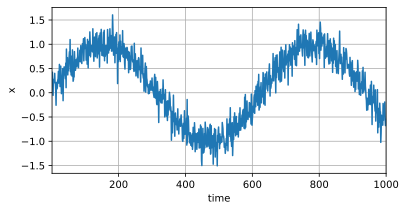

In [7]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32) #时间是1,1001
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,)) #这是数据T=1000 加了一个噪音。
#sin(x) x的取值是[0,2pi] [0,3.1516926] 0.01 * time 最小是 0.01 最大是 而且这个函数取值是[-1, 1]
#函数 torch.normal(0, 0.2, (T,))生成的是​​均值为 0、标准差为 0.2​​ 的正态分布随机数  一维正态分布只需要一个随机变量X来描述，其概率密度函数是单峰曲线（X轴表示取值，Y轴表示概率密度）
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

接下来，我们将这个序列转换为模型的*特征－标签*（feature-label）对。
基于嵌入维度$\tau$，我们[**将数据映射为数据对$y_t = x_t$
和$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$。**]
这比我们提供的数据样本少了$\tau$个，
因为我们没有足够的历史记录来描述前$\tau$个数据样本。
一个简单的解决办法是：如果拥有足够长的序列就丢弃这几项；
另一个方法是用零填充序列。
在这里，我们仅使用前600个“特征－标签”对进行训练。


In [8]:
tau = 4
features = torch.zeros((T - tau, tau)) #T-tau = 1000-4 4   这个数据的特征就是是过去tau个特征。
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
    #：，1所有样本的第一列 也就是i=0,0~996  i=1,1:997 i=2, 2:998  i=3,3:999
labels = x[tau:].reshape((-1, 1))#tau:T行 1列

In [9]:
batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

在这里，我们[**使用一个相当简单的架构训练模型：
一个拥有两个全连接层的多层感知机**]，ReLU激活函数和平方损失。


In [10]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

现在，准备[**训练模型**]了。实现下面的训练代码的方式与前面几节（如 :numref:`sec_linear_concise`）中的循环训练基本相同。因此，我们不会深入探讨太多细节。


In [11]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.060139
epoch 2, loss: 0.050622
epoch 3, loss: 0.050979
epoch 4, loss: 0.049070
epoch 5, loss: 0.049079


## 预测

由于训练损失很小，因此我们期望模型能有很好的工作效果。
让我们看看这在实践中意味着什么。
首先是检查[**模型预测下一个时间步**]的能力，
也就是*单步预测*（one-step-ahead prediction）。


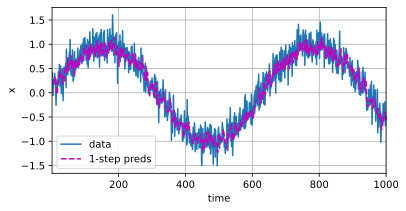

In [12]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

正如我们所料，单步预测效果不错。
即使这些预测的时间步超过了$600+4$（`n_train + tau`），
其结果看起来仍然是可信的。
然而有一个小问题：如果数据观察序列的时间步只到$604$，
我们需要一步一步地向前迈进：
$$
\hat{x}_{605} = f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} = f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} = f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} = f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} = f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
\ldots
$$

通常，对于直到$x_t$的观测序列，其在时间步$t+k$处的预测输出$\hat{x}_{t+k}$
称为$k$*步预测*（$k$-step-ahead-prediction）。
由于我们的观察已经到了$x_{604}$，它的$k$步预测是$\hat{x}_{604+k}$。
换句话说，我们必须使用我们自己的预测（而不是原始数据）来[**进行多步预测**]。
让我们看看效果如何。


In [13]:
multistep_preds = torch.zeros(T) #多步预测 1000个多步预测
multistep_preds[: n_train + tau] = x[: n_train + tau] #n_Train=600+4 给前604赋了个值 后面没有赋
for i in range(n_train + tau, T): #600+4  1000
    multistep_preds[i] = net(#后面这604到1000是做预测用的。 604
        multistep_preds[i - tau:i].reshape((1, -1)))# 604-4:604 1:4 对是这样的 预测了605 然后再根据601-605 预测了606 然后再根据602-606 预测了607等等 最后前面的数字都是根据前面几个预测的。

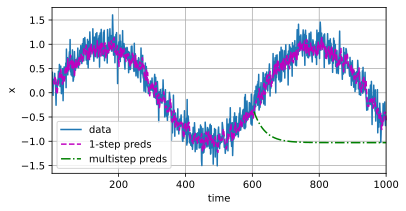

In [14]:
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

如上面的例子所示，绿线的预测显然并不理想。
经过几个预测步骤之后，预测的结果很快就会衰减到一个常数。
为什么这个算法效果这么差呢？事实是由于错误的累积：
假设在步骤$1$之后，我们积累了一些错误$\epsilon_1 = \bar\epsilon$。
于是，步骤$2$的输入被扰动了$\epsilon_1$，
结果积累的误差是依照次序的$\epsilon_2 = \bar\epsilon + c \epsilon_1$，
其中$c$为某个常数，后面的预测误差依此类推。
因此误差可能会相当快地偏离真实的观测结果。
例如，未来$24$小时的天气预报往往相当准确，
但超过这一点，精度就会迅速下降。
我们将在本章及后续章节中讨论如何改进这一点。

基于$k = 1, 4, 16, 64$，通过对整个序列预测的计算，
让我们[**更仔细地看一下$k$步预测**]的困难。


In [15]:
max_steps = 64

In [21]:
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps)) #1000-4-64+1, 4+64 前面是预测的个数 后面是前4个是特征 接着是预测结果。
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau): #0-4
    features[:, i] = x[i: i + T - tau - max_steps + 1]
    # i=0: features[:,0] = x[0:0+1000-4-64+1]
    # i=1: features[:,1] = x[1:1+1000-4-64+1]
    # i=2: features[:,2] = x[2:2+1000-4-64+1]
    # ...
    # i=3: features[:,3] = x[3:3+1000-4-64+1] 后面64个维度是输出结果
# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps): #这里前四个是输入的特征。从第四列开始到64+4 都是预测的结果。  tau, tau + max_steps是4:68
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)
    # i=4: features[:, 0:4]
    # i=5: features[:, 1:5]
    # i=6: features[:, 2:6]
    # ...
    # i=67: features[:, 63:67]

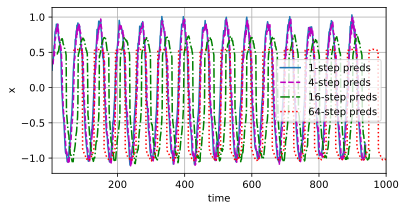

In [24]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))


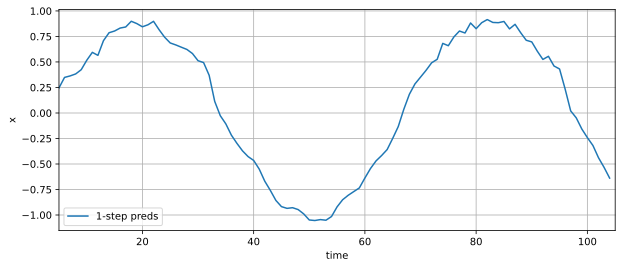

In [23]:
steps = (1,)  # 保持元组格式，即使只有一个步长
display_length = 100  # 要显示的数据点数量

d2l.plot([time[tau + i - 1: tau + i - 1 + display_length] for i in steps],  # 只取前100个时间点
         [features[:display_length, (tau + i - 1)].detach().numpy() for i in steps],  # 只取前100个预测结果
         'time', 'x',
         legend=[f'{i}-step preds' for i in steps],
         xlim=[time[tau], time[tau + display_length]],  # 调整x轴范围
         figsize=(10, 4))  # 加宽图形以便更清晰显示

以上例子清楚地说明了当我们试图预测更远的未来时，预测的质量是如何变化的。
虽然“$4$步预测”看起来仍然不错，但超过这个跨度的任何预测几乎都是无用的。

## 小结

* 内插法（在现有观测值之间进行估计）和外推法（对超出已知观测范围进行预测）在实践的难度上差别很大。因此，对于所拥有的序列数据，在训练时始终要尊重其时间顺序，即最好不要基于未来的数据进行训练。
* 序列模型的估计需要专门的统计工具，两种较流行的选择是自回归模型和隐变量自回归模型。
* 对于时间是向前推进的因果模型，正向估计通常比反向估计更容易。
* 对于直到时间步$t$的观测序列，其在时间步$t+k$的预测输出是“$k$步预测”。随着我们对预测时间$k$值的增加，会造成误差的快速累积和预测质量的极速下降。

## 练习

1. 改进本节实验中的模型。
    1. 是否包含了过去$4$个以上的观测结果？真实值需要是多少个？
    1. 如果没有噪音，需要多少个过去的观测结果？提示：把$\sin$和$\cos$写成微分方程。
    1. 可以在保持特征总数不变的情况下合并旧的观察结果吗？这能提高正确度吗？为什么？
    1. 改变神经网络架构并评估其性能。
1. 一位投资者想要找到一种好的证券来购买。他查看过去的回报，以决定哪一种可能是表现良好的。这一策略可能会出什么问题呢？
1. 时间是向前推进的因果模型在多大程度上适用于文本呢？
1. 举例说明什么时候可能需要隐变量自回归模型来捕捉数据的动力学模型。


1.1
当前模型的观测值使用情况
仅使用过去4个观测值：当前模型的特征始终是严格过去4个时间步的数据（features[:0:4]）。
预测时不使用额外观测值：在多步预测循环中（i >= tau），每一步的预测仅基于前4个值（可能是观测值或之前的预测值），不包含更早的历史数据。

2.2-1 关于方程需要几个观测值才能预测下一个结果的问题 主要看方程的阶数，一阶函数 一阶函数，也称为一次函数，是最基本的函数形式之一。它的一般形式为y=ax+b，其中a和b是常数，a称为斜率，代表了函数图像的倾斜程度。当x变化一个单位时，y会相应地变化a个单位。一次函数的图像是一条直线，具有直观、易于理解的特性。
要回答“关于一个方程需要几个观测值就能达到预测下一个结果，主要是看方程的什么？”这个问题，关键在于理解方程的参数数量（或称为自由度）。

2.2-2 **正弦函数参数与观测值关系**

关键点：正弦函数的参数决定最小观测值 **加粗文字**

一个通用的正弦函数可表示为：

$$ y = A\sin(\omega x + \phi) + C $$

其中包含4个未知参数：

1. **振幅A**（波峰高度）
2. **角频率ω**（周期长度，$ \omega = \frac{2\pi}{T} $，T是周期）
3. **相位φ**（水平偏移）
4. **垂直偏移C**（基准线位置）

理论需求：至少需要4个观测值

理论上，至少需要4个观测值才能唯一确定所有参数并预测下一个值。

**为什么需要4个观测值？**

1. **参数与方程的关系**：
   - 每个观测值$(x_i, y_i)$提供一个方程：$ y_i = A\sin(\omega x_i + \phi) + C $
   - 4个未知参数需要至少4个独立方程（即4个观测点）才能求解

2. **示例**：
   假设在$x=0$, $\frac{\pi}{2}$, $\pi$, $\frac{3\pi}{2}$处测得y值：
通过解此方程组可求出A, ω, φ, C，进而预测任意x处的y

**特殊情况：已知部分参数时可减少观测值**

若提前知道部分参数，所需观测值会减少：
**情况1：已知周期T（即ω）和C=0**
- 参数简化为$A, \phi$，至少需2个观测值
- 示例（已知T=2π且C=0）：
联立可解A和φ

**情况2：已知振幅A、周期T、无偏移（C=0）**
- 只剩相位φ，仅需1个观测值即可确定相位并预测

1.2-3
**使用MLP模拟正弦函数的最小观测值需求**

**核心结论**
使用多层感知机(MLP)模拟正弦函数时，所需最小观测值数量如下：

| 函数类型                | 最小观测点数 | 需要确定的参数          |
|-------------------------|--------------|-------------------------|
| 基本正弦函数 y=Asin(ωx+φ) | 3            | A（振幅）、ω（频率）、φ（相位） |
| 带偏移正弦函数 y=Asin(ωx+φ)+C | 4            | 增加C（垂直偏移）        |

**数学原理**

**微分方程基础**
正弦函数是以下微分方程的解：
d²y/dx² + ω²y = 0 #核心就是这个  主要是从物理上采集摆垂运行，然后通过二阶倒数来描述其加速度等 来求出来的函数解是余弦函数。

Epoch 20, Loss: 0.0548
Epoch 40, Loss: 0.0214
Epoch 60, Loss: 0.0212
Epoch 80, Loss: 0.0206
Epoch 100, Loss: 0.0203
Test MSE: 0.0204


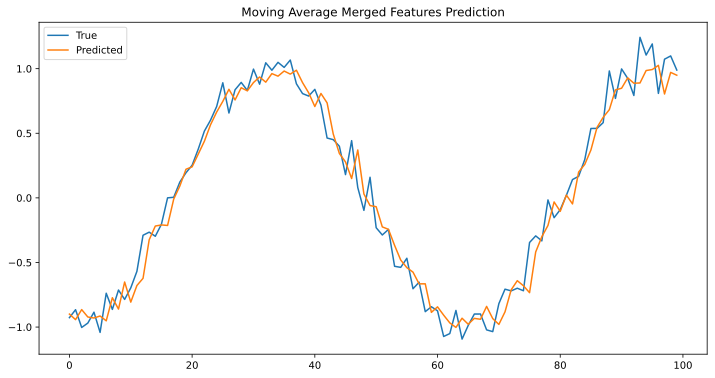

'\n# 10. 对比原始特征模型的性能（可选）\nclass OriginalModel(nn.Module):\n    def __init__(self):\n        super(OriginalModel, self).__init__()\n        self.net = nn.Sequential(\n            nn.Linear(tau, 16),\n            nn.ReLU(),\n            nn.Linear(16, 16),\n            nn.ReLU(),\n            nn.Linear(16, 1))\n        \noriginal_model = OriginalModel()\noptimizer = optim.Adam(original_model.parameters(), lr=0.01)\ntrain(original_model, features[:split_idx], train_y, epochs=100)\nprint("\nOriginal features performance:")\nevaluate(original_model, features[split_idx:], test_y)\n'

In [19]:
#1.3
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 假设我们有一个时间序列数据x，长度为T
T = 1000
x = torch.sin(torch.arange(0, T) * 0.1) + torch.randn(T) * 0.1  # 正弦波+噪声

# 参数设置
tau = 4  # 使用过去4个时间步作为特征
test_ratio = 0.2  # 测试集比例

# 方案1：移动平均合并实现 --------------------------------------------

# 1. 创建原始特征矩阵 (T-tau, tau)
features = torch.zeros((T - tau, tau)) #1000-4, 4
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
    #i = 0,  features[:, 0] =x[0:1000-4+0]
    #i = 1,  features[:, 1] =x[1:1000-4+1]
    #i = 2,  features[:, 2] =x[2:1000-4+2]
    #i = 3,  features[:, 3] =x[3:1000-4+3]

# 2. 合并特征：计算均值和趋势
#要把features改成下面这个
merged_features = torch.zeros((T - tau, 2))#1000-4,2
merged_features[:, 0] = features.mean(dim=1)  # 平均值特征
#features.mean(dim=1)是四个特征维度求平均
merged_features[:, 1] = features[:, -1] - features[:, 0]  # 趋势特征（最新值-最早值）
#features中最新的特征维度-最早的特征维度
# 3. 准备标签（下一个时间步的值）
labels = x[tau:].reshape((-1, 1))
#x[4:] 1000*1
# 4. 划分训练集和测试集
split_idx = int((T - tau) * (1 - test_ratio))
#(1000-4)*0.8
train_X, test_X = merged_features[:split_idx], merged_features[split_idx:]
train_y, test_y = labels[:split_idx], labels[split_idx:]

# 5. 定义MLP模型（适配合并后的2个特征）
class MAModel(nn.Module):
    def __init__(self):
        super(MAModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),  # 输入2个合并特征
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1))

    def forward(self, x):
        return self.net(x)

# 6. 初始化模型和优化器
model = MAModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 7. 训练循环
def train(model, X, y, epochs=100):
    model.train()
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if (epoch+1) % 20 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')
    return losses

train_losses = train(model, train_X, train_y, epochs=100)

# 8. 评估函数
def evaluate(model, X, y):
    model.eval() #模型测试
    with torch.no_grad():
        preds = model(X)
        mse = criterion(preds, y)
        print(f'Test MSE: {mse.item():.4f}')

        # 可视化前100个预测点
        plt.figure(figsize=(12, 6))
        plt.plot(y[:100].numpy(), label='True')
        plt.plot(preds[:100].numpy(), label='Predicted')
        plt.legend()
        plt.title('Moving Average Merged Features Prediction')
        plt.show()

# 9. 评估模型
evaluate(model, test_X, test_y)

"""
# 10. 对比原始特征模型的性能（可选）
class OriginalModel(nn.Module):
    def __init__(self):
        super(OriginalModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(tau, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1))

original_model = OriginalModel()
optimizer = optim.Adam(original_model.parameters(), lr=0.01)
train(original_model, features[:split_idx], train_y, epochs=100)
print("\nOriginal features performance:")
evaluate(original_model, features[split_idx:], test_y)
"""

[Discussions](https://discuss.d2l.ai/t/2091)
